# Remove a water level event as identified by first tidal filtering using Eli's SCHA method and then removing the seasonal signal (performed using 40 day boxcar)

In [1]:
#import xarray as xr

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [3]:
#UPDATE 09/21 use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
#pr_filt.set_index("datetime",inplace=True)
pr_filt

,datetime,Residual
0,2012-01-03 01:30:00,NaN
1,2012-01-03 02:00:00,NaN
2,2012-01-03 02:30:00,NaN
3,2012-01-03 03:00:00,NaN
4,2012-01-03 03:30:00,NaN
...,...,...
210182,2023-12-29 20:30:00,NaN
210183,2023-12-29 21:00:00,NaN
210184,2023-12-29 21:30:00,NaN
210185,2023-12-29 22:00:00,NaN


In [4]:
#load point reyes
colnames=['datetime','elev[m]']
dtformat = '%Y-%m-%dT%H:%M:%S'
#pryc=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/pryc1default_elev_screened_2021.csv', skiprows=73)
dtformat = '%Y-%m-%dT%H:%M'
pryc=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_9415020_9415020_water_level_1950_2021.csv', 
                 skiprows=9,header=0,
                 names=['datetime','elev[m]','sigma','verified','F','R','L','quality'])
pryc['datetime']=pd.to_datetime(pryc['datetime'],format=dtformat)#.asfreq('15min')
# #pryc.set_index("datetime",inplace=True)
# pryc=pryc.rename(columns={"value": "elev[m]"})
pryc
# pryc=pryc.asfreq('6min')
# #drop user_flag
# pryc.drop(columns='user_flag',inplace=True)
# #change value to elev[m]
# pryc=pryc.rename(columns={"value": "elev[m]"})
# pryc_filt=filter_timeseries(pryc)
# pryc_filt

,datetime,elev[m],sigma,verified,F,R,L,quality
0,1995-12-01 00:06:00,NaN,NaN,1,1,1,1,p
1,1995-12-01 00:12:00,NaN,NaN,1,1,1,1,p
2,1995-12-01 00:18:00,NaN,NaN,1,1,1,1,p
3,1995-12-01 00:24:00,NaN,NaN,1,1,1,1,p
4,1995-12-01 00:30:00,NaN,NaN,1,1,1,1,p
...,...,...,...,...,...,...,...,...
2261769,2021-10-01 23:30:00,0.479,0.033,0,0,0,0,v
2261770,2021-10-01 23:36:00,0.467,0.052,0,0,0,0,v
2261771,2021-10-01 23:42:00,0.451,0.034,0,0,0,0,v
2261772,2021-10-01 23:48:00,0.412,0.042,0,0,0,0,v


# Look at an event of interest, raw and filtered data

(18444.0, 18628.0)

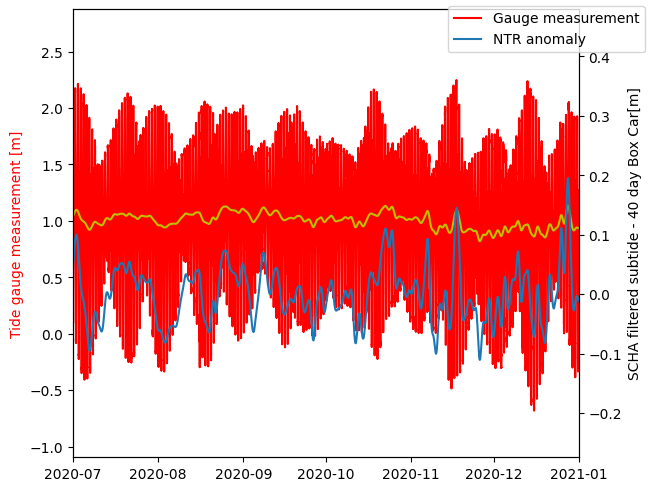

In [5]:
fig, ax = plt.subplots(layout='constrained',sharex=True)

ax.plot(pryc['datetime'],pryc['elev[m]'],label='Gauge measurement',color='r')
ax.plot(ptreyes['datetime'],ptreyes['subtide'],color='y')
ax.set_ylabel('Tide gauge measurement [m]',color='r')

ax2=ax.twinx()
ax2.plot(pr_filt['datetime'],pr_filt['Residual'],label='NTR anomaly')
ax2.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')

fig.legend()
ax.set_xlim(datetime(2020,7,1),datetime(2021,1,1))

(18536.0, 18565.0)

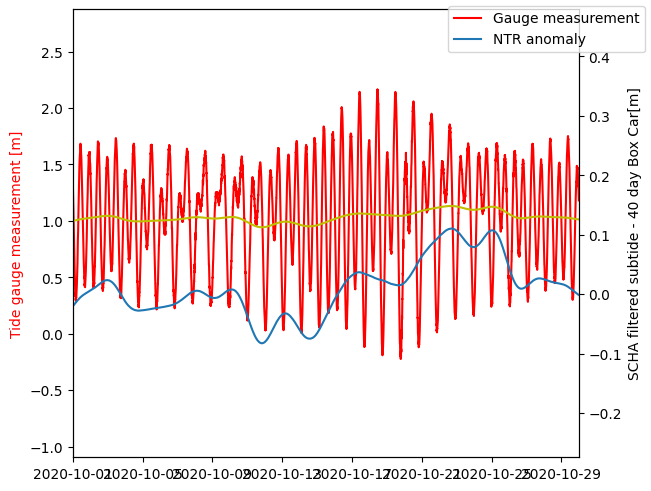

In [6]:
fig, ax = plt.subplots(layout='constrained',sharex=True)

ax.plot(pryc['datetime'],pryc['elev[m]'],label='Gauge measurement',color='r')
ax.plot(ptreyes['datetime'],ptreyes['subtide'],color='y')
ax.set_ylabel('Tide gauge measurement [m]',color='r')
ax2=ax.twinx()
ax2.plot(pr_filt['datetime'],pr_filt['Residual'],label='NTR anomaly')
ax2.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')

fig.legend()
ax.set_xlim(datetime(2020,10,1),datetime(2020,10,30))

(18536.0, 18565.0)

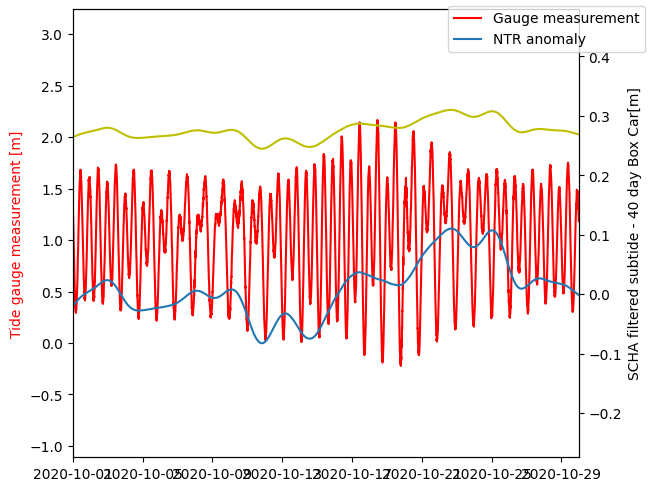

In [7]:
fig, ax = plt.subplots(layout='constrained',sharex=True)

ax.plot(pryc['datetime'],pryc['elev[m]'],label='Gauge measurement',color='r')
ax.plot(ptreyes['datetime'],ptreyes['subtide']*2,color='y')
ax.set_ylabel('Tide gauge measurement [m]',color='r')
ax2=ax.twinx()
ax2.plot(pr_filt['datetime'],pr_filt['Residual'],label='NTR anomaly')
ax2.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')

fig.legend()
ax.set_xlim(datetime(2020,10,1),datetime(2020,10,30))

# Reconstruct a tidal signal using the subtide

In [8]:
pryc.set_index("datetime",inplace=True)
pr_filt.set_index("datetime",inplace=True)
pr_filt=pr_filt.asfreq('30min')

In [9]:
#first need to interpolate subtide to have the same frequency as the raw signal
# subtide_interp=pr_filt
subtide_interp=pr_filt.asfreq('6min').interpolate(method='linear')
subtide_interp
# pryc['cleaned_subtide']=subtide_interp
# pryc['supra']=pryc['elev[m]'].sub(pryc['cleaned_subtide'])
# pryc

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 01:36:00,NaN
2012-01-03 01:42:00,NaN
2012-01-03 01:48:00,NaN
2012-01-03 01:54:00,NaN
...,...
2023-12-29 22:06:00,-0.105951
2023-12-29 22:12:00,-0.105951
2023-12-29 22:18:00,-0.105951


<AxesSubplot:xlabel='datetime'>

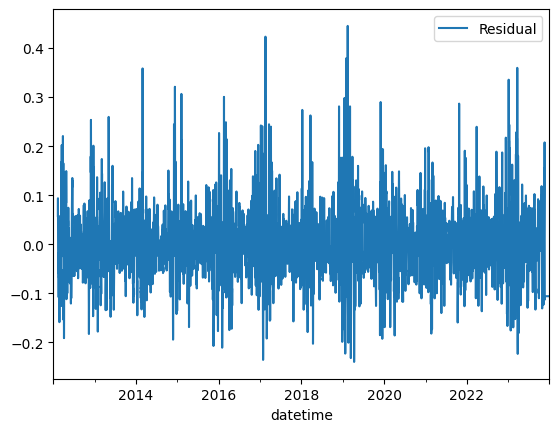

In [10]:
subtide_interp.plot()

In [11]:
pryc_calc=pd.concat([pryc,subtide_interp],axis=1)
pryc_calc

,elev[m],sigma,verified,F,R,L,quality,Residual
datetime,,,,,,,,
1995-12-01 00:06:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN
1995-12-01 00:12:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN
1995-12-01 00:18:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN
1995-12-01 00:24:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN
1995-12-01 00:30:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN
...,...,...,...,...,...,...,...,...
2023-12-29 22:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.105951
2023-12-29 22:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.105951
2023-12-29 22:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.105951


In [12]:
pryc_calc['supra']=pryc_calc['elev[m]'].sub(pryc_calc['Residual'])

<AxesSubplot:xlabel='datetime'>

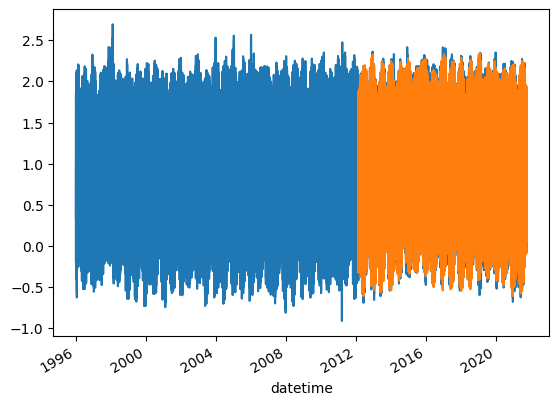

In [13]:
pryc_calc['elev[m]'].plot()
pryc_calc['supra'].plot()

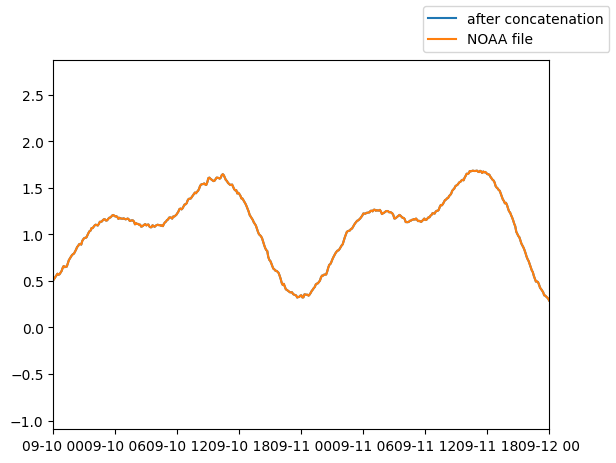

In [29]:
#EDIT 09/27 did something happen that shifted the time of elev?
fig, ax = plt.subplots()

ax.plot(pryc_calc['elev[m]'],label='after concatenation')
ax.plot(pryc['elev[m]'],label='NOAA file')
ax.set_xlim(datetime(2020,9,10),datetime(2020,9,12))
fig.legend()
plt.show()

# repeat for Monterey Bay

In [14]:
#UPDATE 09/21 use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
monterey=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_monterey.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
monterey['datetime'] = pd.to_datetime(monterey['datetime'],format=dtformat)
mb_filt=monterey[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
mb_filt.set_index("datetime",inplace=True)
mb_filt=mb_filt.asfreq('30min')
mb_filt



,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


In [15]:
#load Monterey
colnames=['datetime','elev[m]']
#different datetime format for NOAA
dtformat = '%Y-%m-%dT%H:%M'
mbyc=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_9413450_9413450_water_level_1950_2021.csv', 
                 skiprows=9,header=0,
                 names=['datetime','elev[m]','sigma','verified','F','R','L','quality'])
mbyc['datetime']=pd.to_datetime(mbyc['datetime'],format=dtformat)#.asfreq('15min')
mbyc.set_index("datetime",inplace=True)
#mbyc=mbyc.rename(columns={"value": "elev[m]"})
mbyc


,elev[m],sigma,verified,F,R,L,quality
datetime,,,,,,,
1995-12-01 00:06:00,NaN,NaN,1,1,1,1,p
1995-12-01 00:12:00,NaN,NaN,1,1,1,1,p
1995-12-01 00:18:00,NaN,NaN,1,1,1,1,p
1995-12-01 00:24:00,NaN,NaN,1,1,1,1,p
1995-12-01 00:30:00,NaN,NaN,1,1,1,1,p
...,...,...,...,...,...,...,...
2021-10-01 23:30:00,0.423,0.076,0,0,0,0,v
2021-10-01 23:36:00,0.378,0.122,0,0,0,0,v
2021-10-01 23:42:00,0.375,0.083,0,0,0,0,v


In [24]:
subtide_interp_m=mb_filt.asfreq('6min').interpolate(method='linear')
subtide_interp_m
mbyc_calc=pd.concat([mbyc,subtide_interp_m],axis=1)
mbyc_calc['supra']=mbyc_calc['elev[m]'].sub(mbyc_calc['Residual'])

In [25]:
subtide_interp_m

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 01:36:00,NaN
2012-01-03 01:42:00,NaN
2012-01-03 01:48:00,NaN
2012-01-03 01:54:00,NaN
...,...
2023-12-29 22:06:00,-0.066731
2023-12-29 22:12:00,-0.066731
2023-12-29 22:18:00,-0.066731


In [19]:
mbyc_calc

,elev[m],sigma,verified,F,R,L,quality,Residual,supra
datetime,,,,,,,,,
1995-12-01 00:06:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN
1995-12-01 00:12:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN
1995-12-01 00:18:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN
1995-12-01 00:24:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN
1995-12-01 00:30:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-12-29 22:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN
2023-12-29 22:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN
2023-12-29 22:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN


<AxesSubplot:xlabel='datetime'>

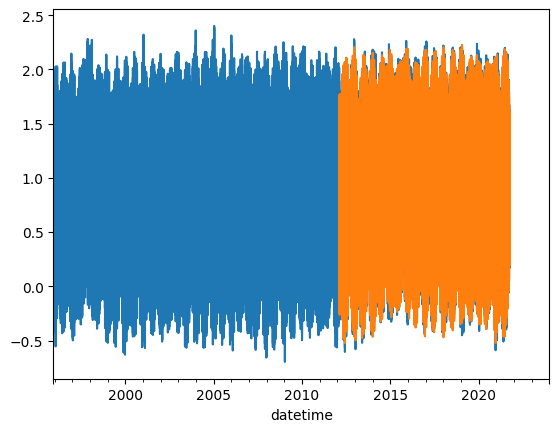

In [26]:
mbyc_calc['elev[m]'].plot()
mbyc_calc['supra'].plot()

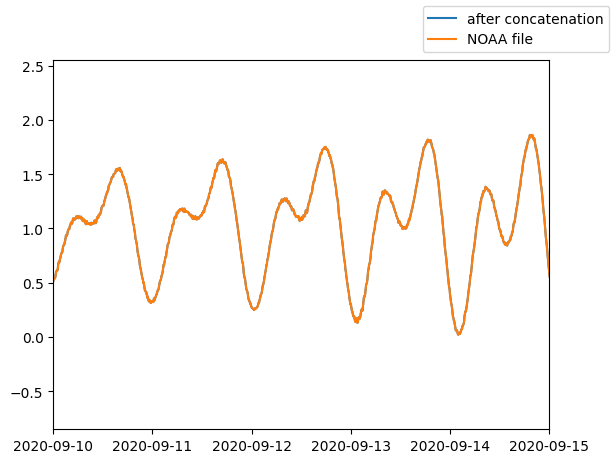

In [27]:
#EDIT 09/27 did something happen that shifted the time of elev?
fig, ax = plt.subplots()

ax.plot(mbyc_calc['elev[m]'],label='after concatenation')
ax.plot(mbyc['elev[m]'],label='NOAA file')
ax.set_xlim(datetime(2020,9,10),datetime(2020,9,15))
fig.legend()
plt.show()

# Remove an event from subtide and add the subtide back to the backgroud tide

(18536.0, 18565.0)

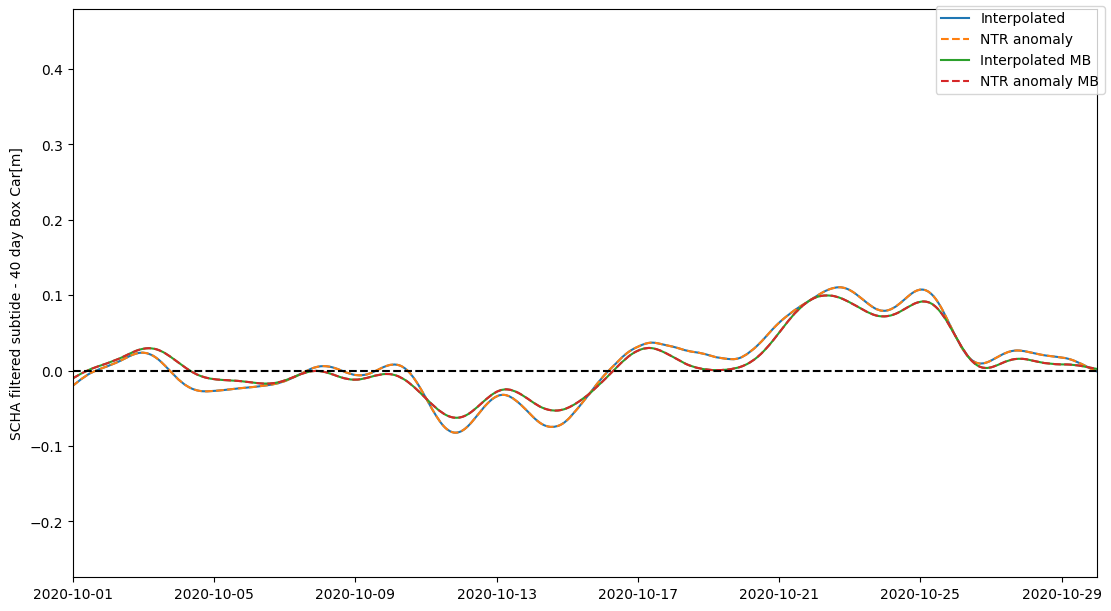

In [30]:
#zoom in on the end of october, plot both the interpolated and original filtered signals
fig, ax=plt.subplots(figsize=(11,6),layout='constrained')
ax.plot(pryc_calc['Residual'],label='Interpolated')
ax.plot(pr_filt['Residual'],label='NTR anomaly',linestyle='--')
ax.plot(mbyc_calc['Residual'],label='Interpolated MB')
ax.plot(mb_filt['Residual'],label='NTR anomaly MB',linestyle='--')
ax.axhline(y=0, color = 'k',linestyle='--')
ax.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')
fig.legend()
ax.set_xlim(datetime(2020,10,1),datetime(2020,10,30))

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<AxesSubplot:xlabel='datetime'>

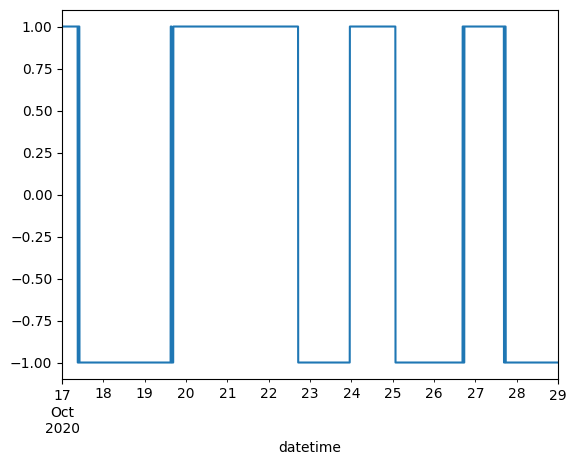

In [19]:
#interpolated looks the same, use that signal
#maybe don't actually use the roots, use the inflection points between 10/17 and 10/21 and also 10/25 to 10/29
snip=pryc_calc[datetime(2020,10,17):datetime(2020,10,29)]
snip['diff'] = snip['Residual'].diff()
snip['sign'] =  np.sign(snip['diff'])
snip['sign'].plot()
# # find switching points
# infls = (np.sign(snip['diff'])))[0]
# # infls

<AxesSubplot:xlabel='datetime'>

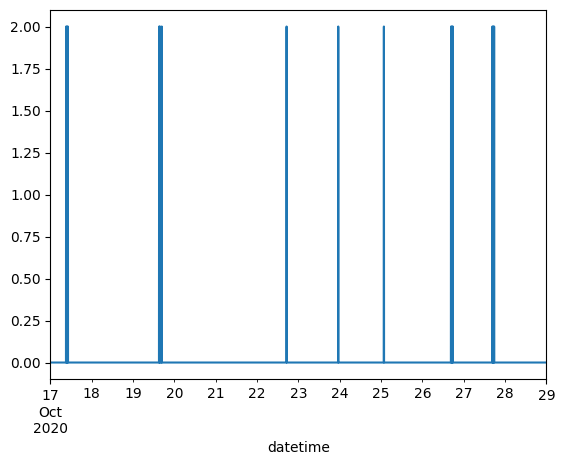

In [20]:
#snip.where(np.abs(snip['sign'].diff())==2).dropna()
np.abs(snip['sign'].diff()).plot()

In [21]:
snip['Residual'].where(np.abs(snip['sign'].diff())==2).dropna()

datetime
2020-10-17 09:06:00    0.037092
2020-10-17 09:36:00    0.037076
2020-10-17 10:06:00    0.037120
2020-10-19 15:06:00    0.015171
2020-10-19 15:36:00    0.015201
2020-10-19 16:36:00    0.015122
2020-10-22 17:06:00    0.110642
2020-10-23 23:06:00    0.079322
2020-10-25 01:36:00    0.107545
2020-10-26 16:36:00    0.009393
2020-10-26 17:06:00    0.009423
2020-10-26 17:36:00    0.009411
2020-10-27 16:36:00    0.026653
2020-10-27 17:06:00    0.026671
2020-10-27 17:36:00    0.026747
Name: Residual, dtype: float64

<AxesSubplot:xlabel='datetime'>

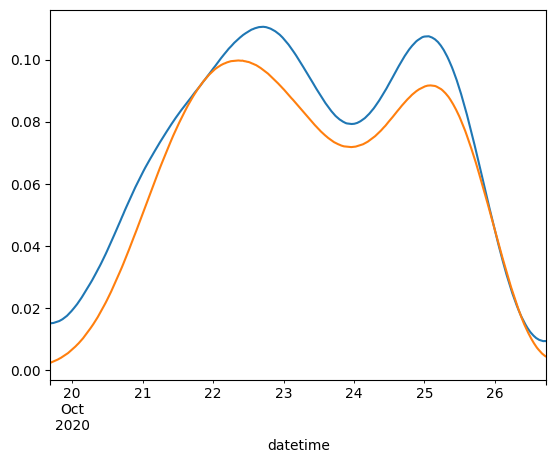

In [31]:
#choose dates for start and end
strim=datetime(2020,10,19,16,36,0)
etrim=datetime(2020,10,26,17,36,0)
pryc_calc['Residual'][strim:etrim].plot()
mbyc_calc['Residual'][strim:etrim].plot()

In [32]:
#interpolate between the start point and end
pryc_calc['removed']=pryc_calc['Residual']
pryc_calc['removed'][strim:etrim]=np.nan
pryc_calc['removed']=pryc_calc['removed'].interpolate(method='linear')

mbyc_calc['removed']=mbyc_calc['Residual']
mbyc_calc['removed'][strim:etrim]=np.nan
mbyc_calc['removed']=mbyc_calc['removed'].interpolate(method='linear')

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(18553.0, 18562.0)

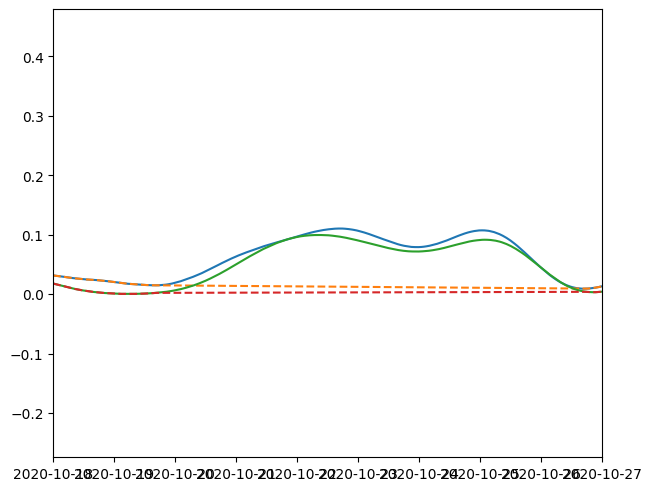

In [33]:
fig, ax = plt.subplots(layout='constrained',sharex=True)
ax.plot(pryc_calc['Residual'])
ax.plot(pryc_calc['removed'],linestyle='--')
ax.plot(mbyc_calc['Residual'])
ax.plot(mbyc_calc['removed'],linestyle='--')
ax.set_xlim(datetime(2020,10,18),datetime(2020,10,27))

# Now add the subtide with event removed to 'supra' (the difference between the raw tidal signal and the subtidal residual with box car subtracted)

In [34]:
pryc_calc['hifi_removed']=pryc_calc['supra']+pryc_calc['removed']
mbyc_calc['hifi_removed']=mbyc_calc['supra']+mbyc_calc['removed']

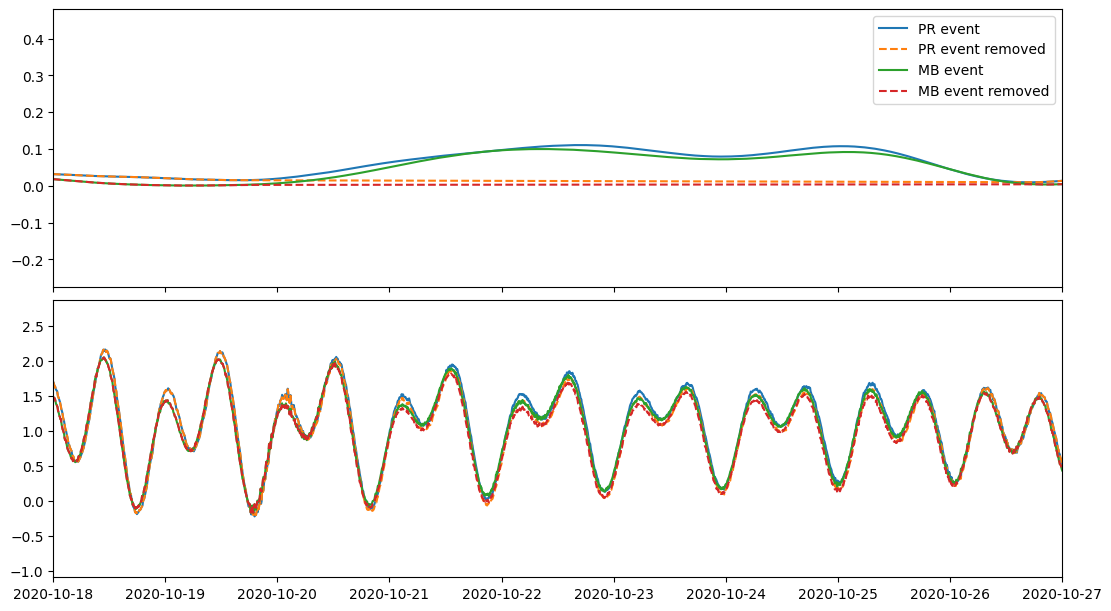

In [35]:
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True,figsize=[11,6])
ax[0].plot(pryc_calc['Residual'],label='PR event')
ax[0].plot(pryc_calc['removed'],linestyle='--',label='PR event removed')
ax[0].plot(mbyc_calc['Residual'],label='MB event')
ax[0].plot(mbyc_calc['removed'],linestyle='--',label='MB event removed')
ax[0].legend()
ax[0].set_xlim(datetime(2020,10,18),datetime(2020,10,27))

ax[1].plot(pryc_calc['elev[m]'])
ax[1].plot(pryc_calc['hifi_removed'],linestyle='--')
ax[1].plot(mbyc_calc['elev[m]'])
ax[1].plot(mbyc_calc['hifi_removed'],linestyle='--')
plt.show()

# Need to export these files so they look like the NOAA files (maybe add the header in postprocessing though)

In [27]:
mbyc_calc

,elev[m],sigma,verified,F,R,L,quality,Residual,supra,removed,hifi_removed
datetime,,,,,,,,,,,
1995-12-01 00:06:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN,NaN,NaN
1995-12-01 00:12:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN,NaN,NaN
1995-12-01 00:18:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN,NaN,NaN
1995-12-01 00:24:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN,NaN,NaN
1995-12-01 00:30:00,NaN,NaN,1.0,1.0,1.0,1.0,p,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 22:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN,-0.066731,NaN
2023-12-29 22:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN,-0.066731,NaN
2023-12-29 22:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066731,NaN,-0.066731,NaN


# Repeat for Monterey Bay

# Calculate Tidal energy

In [28]:
pryc=pryc.asfreq('6min')
pryc['elev_cos']=filter_timeseries(pryc['elev[m]'])

In [29]:
#tidal RMS should NOT coicide with the subtidal peaks


# pryc['elev_shift']=pryc['elev[m]']-pryc['elev[m]'].mean()
pryc['mse_raw']=(pryc['elev[m]'].sub(pryc['elev_cos']))**2
pryc['mse']=filter_timeseries(pryc['mse_raw'])

In [30]:
pryc['mse']

datetime
1995-12-01 00:06:00   NaN
1995-12-01 00:12:00   NaN
1995-12-01 00:18:00   NaN
1995-12-01 00:24:00   NaN
1995-12-01 00:30:00   NaN
                       ..
2021-10-01 23:30:00   NaN
2021-10-01 23:36:00   NaN
2021-10-01 23:42:00   NaN
2021-10-01 23:48:00   NaN
2021-10-01 23:54:00   NaN
Freq: 6T, Name: mse, Length: 2264879, dtype: float64

<AxesSubplot:xlabel='datetime'>

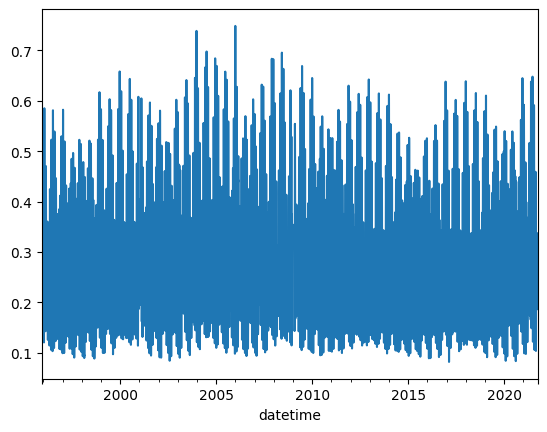

In [31]:
pryc['mse'].plot()

(18536.0, 18565.0)

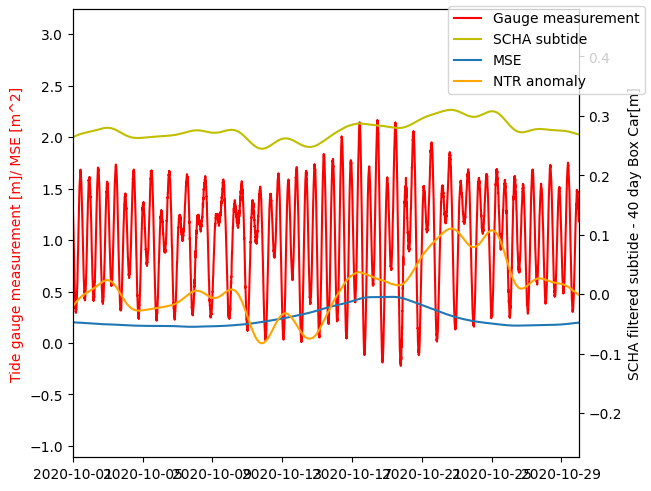

In [32]:
fig, ax = plt.subplots(layout='constrained',sharex=True)

ax.plot(pryc['elev[m]'],label='Gauge measurement',color='r')
ax.plot(ptreyes['datetime'],ptreyes['subtide']*2,color='y',label='SCHA subtide')
ax.plot(pryc['mse'],label = 'MSE')
ax.set_ylabel('Tide gauge measurement [m]/ MSE [m^2]',color='r')
ax2=ax.twinx()
ax2.plot(pr_filt['Residual'],label='NTR anomaly',color='orange')
ax2.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')

fig.legend()
ax.set_xlim(datetime(2020,10,1),datetime(2020,10,30))

(18444.0, 18627.0)

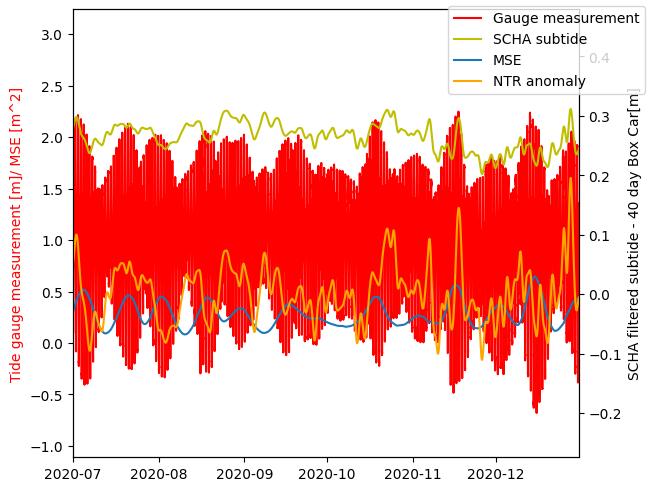

In [33]:
fig, ax = plt.subplots(layout='constrained',sharex=True)

ax.plot(pryc['elev[m]'],label='Gauge measurement',color='r')
ax.plot(ptreyes['datetime'],ptreyes['subtide']*2,color='y',label='SCHA subtide')
ax.plot(pryc['mse'],label = 'MSE')
ax.set_ylabel('Tide gauge measurement [m]/ MSE [m^2]',color='r')
ax2=ax.twinx()
ax2.plot(pr_filt['Residual'],label='NTR anomaly',color='orange')
ax2.set_ylabel('SCHA filtered subtide - 40 day Box Car[m]')

fig.legend()
ax.set_xlim(datetime(2020,7,1),datetime(2020,12,31))

# Trim the tidal dataframes so there is a month on either side of the run we want to do:
need 16 days of nudging before event of interest starts on 10/18, would need to start 10/02 or earier, closest prior cruise date is 9/10, would want to run at least a week after the water level event ends on 10/27, best to have 2, end date around November 10, month on either side, August 1 to December 31

In [36]:
prtosave=pryc_calc[datetime(2020,8,1):datetime(2020,12,31)][['elev[m]','sigma','verified','F','R','L','quality','hifi_removed']]
mbtosave=mbyc_calc[datetime(2020,8,1):datetime(2020,12,31)][['elev[m]','sigma','verified','F','R','L','quality','hifi_removed']]

In [37]:
prtosave

,elev[m],sigma,verified,F,R,L,quality,hifi_removed
datetime,,,,,,,,
2020-08-01 00:00:00,0.696,0.032,0.0,0.0,0.0,0.0,v,0.696
2020-08-01 00:06:00,0.643,0.022,0.0,0.0,0.0,0.0,v,0.643
2020-08-01 00:12:00,0.612,0.020,0.0,0.0,0.0,0.0,v,0.612
2020-08-01 00:18:00,0.583,0.021,0.0,0.0,0.0,0.0,v,0.583
2020-08-01 00:24:00,0.528,0.017,0.0,0.0,0.0,0.0,v,0.528
...,...,...,...,...,...,...,...,...
2020-12-30 23:36:00,1.320,0.083,0.0,0.0,0.0,0.0,v,1.320
2020-12-30 23:42:00,1.306,0.088,0.0,0.0,0.0,0.0,v,1.306
2020-12-30 23:48:00,1.300,0.093,0.0,0.0,0.0,0.0,v,1.300


In [38]:
mbtosave

,elev[m],sigma,verified,F,R,L,quality,hifi_removed
datetime,,,,,,,,
2020-08-01 00:00:00,0.615,0.026,0.0,0.0,0.0,0.0,v,0.615
2020-08-01 00:06:00,0.568,0.026,0.0,0.0,0.0,0.0,v,0.568
2020-08-01 00:12:00,0.516,0.021,0.0,0.0,0.0,0.0,v,0.516
2020-08-01 00:18:00,0.468,0.023,0.0,0.0,0.0,0.0,v,0.468
2020-08-01 00:24:00,0.436,0.022,0.0,0.0,0.0,0.0,v,0.436
...,...,...,...,...,...,...,...,...
2020-12-30 23:36:00,1.217,0.108,0.0,0.0,0.0,0.0,v,1.217
2020-12-30 23:42:00,1.184,0.088,0.0,0.0,0.0,0.0,v,1.184
2020-12-30 23:48:00,1.188,0.088,0.0,0.0,0.0,0.0,v,1.188


In [39]:
#prtosave.to_csv('/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_ptreyes_event_removed_2020.csv')
mbtosave.to_csv('/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_monterey_event_removed_2020.csv')